# 환경설정

- Public : 8월 30일 ~ 9월 3일 
- Private : 9월 13일 ~ 9월 17일

In [32]:
import pandas as pd
import os
import FinanceDataReader as fdr

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from tqdm import tqdm

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
import numpy as np
import random

from datetime import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = './open_week3'
list_name = 'Stock_List.csv'
stock_list = pd.read_csv(os.path.join(path,list_name), encoding='CP949')
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list # 대형/중형주? 

,종목명,종목코드,상장시장,산업군
0,삼성전자,005930,KOSPI,반도체와반도체장비
1,SK하이닉스,000660,KOSPI,반도체와반도체장비
2,NAVER,035420,KOSPI,양방향미디어와서비스
3,카카오,035720,KOSPI,양방향미디어와서비스
4,삼성바이오로직스,207940,KOSPI,제약
...,...,...,...,...
371,더네이쳐홀딩스,298540,KOSDAQ,"섬유,의류,신발,호화품"
372,코엔텍,029960,KOSDAQ,상업서비스와공급품
373,원익홀딩스,030530,KOSDAQ,반도체와반도체장비
374,웹케시,053580,KOSDAQ,소프트웨어


In [29]:
# 한국 주식만 있음
stock_list.상장시장.unique()

array(['KOSPI', 'KOSDAQ'], dtype=object)

In [44]:
sample_code = stock_list[stock_list.종목명 == '삼성전자'].종목코드[0]
sample_code

'005930'

In [42]:
type(sample_code)

numpy.ndarray

In [55]:
start_date = '20200101'
end_date = '20201231'

In [61]:
stock_list[stock_list.종목명 == '카카오'].종목코드.values[]

array(['035720'], dtype=object)

In [88]:
def draw_plot(company_lst, start_date='20200101', end_date='20201231'):
    stock_lst = []
    for company in company_lst:
        sample_code = stock_list[stock_list.종목명 == company].종목코드.values[0]
        data = fdr.DataReader(sample_code, start = start_date, end = end_date).Close
        data = (data - data.mean()) / data.std()
        plt.plot(data, label = company)
        
    plt.legend()
    plt.show()  

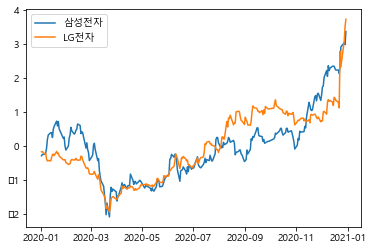

In [79]:
draw_plot(['삼성전자','LG전자'])

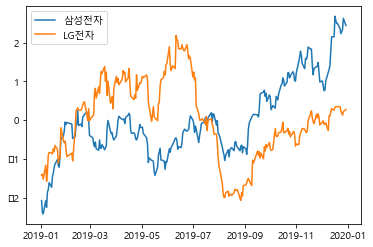

In [89]:
draw_plot(['삼성전자','LG전자'],'20190101','20191231')

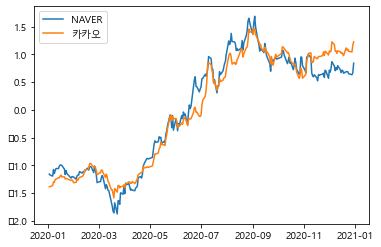

In [80]:
draw_plot(['NAVER','카카오'])

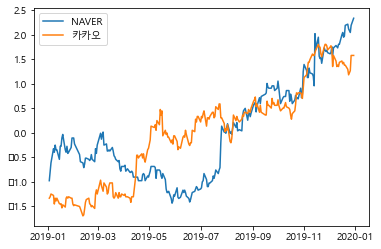

In [90]:
draw_plot(['NAVER','카카오'],'20190101','20191231')

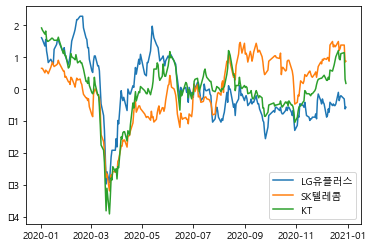

In [83]:
draw_plot(['LG유플러스','SK텔레콤','KT'])

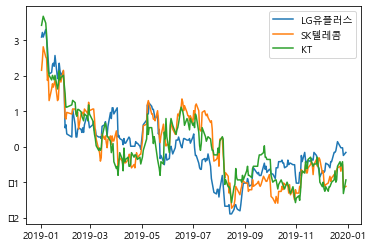

In [91]:
draw_plot(['LG유플러스','SK텔레콤','KT'],'20190101','20191231')

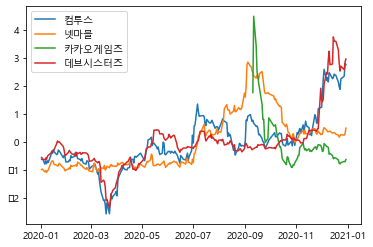

In [85]:
draw_plot(['컴투스','넷마블','카카오게임즈','데브시스터즈'])

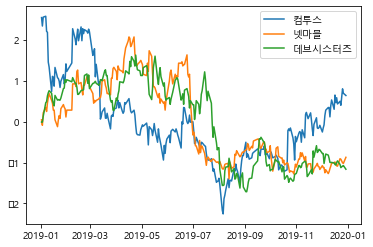

In [93]:
draw_plot(['컴투스','넷마블','데브시스터즈'],'20190101','20191231')

- 산업군마다 주식의 큰 경향성이 존재한다.
- 그 경향성은 주기성이 없다. (19년도와 20년도의 경향성이 크게 다르다)

**1. 종목 군집화**
- 종목들을 군집화해서 각 군집별로 모델을 따로 생성

**2. 종목별 개별 학습**
- 아예 종목별로 모델을 따로 생성 
- 종목이 300개 남짓이기 때문에 종목 개별로 모델을 따로 만드는 것이 가능하긴 함
- 또는, 종목 개별로 모델을 따로 생성하되 그 parameter는 군집별로 같은 parameter을 공유

# baseline
- 학습데이터: 21년 1월 데이터~
- 표준화 적용
- 종목별로 fbpropet 모델 생성
---
**성능**: 7.88

In [152]:
submission = pd.read_csv('./open_week3/sample_submission_week3.csv')
target_day = pd.to_datetime(submission.Day).tolist()

In [224]:
for code in tqdm(stock_list.종목코드):
    data_raw = fdr.DataReader(code, start = '20210101', end = '20210829').Close

    sc = StandardScaler()
    data_scaled = pd.DataFrame({'ds':data_raw.index,
                                'y':sc.fit_transform(data_raw.values.reshape(-1,1)).flatten()})
    m = Prophet(yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False)
    m.fit(data_scaled)
    future = m.make_future_dataframe(periods=21)
    forecast = m.predict(future)

    result = forecast[['ds','yhat']]
    result.yhat = sc.inverse_transform(result.yhat.values.reshape(-1,1))

    submission[code]=result[result.ds.map(lambda x:x in target_day)].yhat.values

100%|████████████████████████████████████████████████████████████████████████████████| 376/376 [09:32<00:00,  1.52s/it]


In [226]:
submission

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-08-30,24476.808598,35572.664940,60957.986805,175154.963825,106365.834814,19598.106391,55149.916363,87831.086509,110117.552164,...,47824.299999,45157.232672,62952.832817,37449.690262,30786.188342,60781.302118,321128.296882,337919.652463,31332.488548,27324.714420
1,2021-08-31,24529.304927,35568.213769,60933.746570,175165.366804,106676.357563,19606.890182,55160.594061,87863.113743,109943.346200,...,47865.448525,45115.657008,63089.215714,37488.131333,30763.809411,60748.984794,321696.616006,338110.883517,31364.985954,27368.939480
2,2021-09-01,24581.801256,35563.762599,60909.506334,175175.769783,106986.880313,19615.673973,55171.271758,87895.140978,109769.140236,...,47906.597052,45074.081344,63225.598612,37526.572405,30741.430479,60716.667469,322264.935130,338302.114570,31397.483359,27413.164540
3,2021-09-02,24634.297585,35559.311428,60885.266099,175186.172761,107297.403062,19624.457764,55181.949455,87927.168212,109594.934273,...,47947.745578,45032.505680,63361.981510,37565.013477,30719.051547,60684.350144,322833.254255,338493.345623,31429.980765,27457.389599
4,2021-09-03,24686.793914,35554.860257,60861.025864,175196.575740,107607.925811,19633.241555,55192.627152,87959.195447,109420.728309,...,47988.894105,44990.930016,63498.364408,37603.454549,30696.672616,60652.032819,323401.573379,338684.576677,31462.478170,27501.614659
5,2021-09-13,25211.757204,35510.348548,60618.623512,175300.605527,110713.153305,19721.079467,55299.404124,88279.467791,107678.668671,...,48400.379369,44575.173373,64862.193385,37987.865266,30472.883299,60328.859571,329084.764620,340596.887210,31787.452224,27943.865259
6,2021-09-14,25264.253533,35505.897377,60594.383276,175311.008506,111023.676054,19729.863258,55310.081821,88311.495025,107504.462707,...,48441.527895,44533.597709,64998.576283,38026.306338,30450.504367,60296.542246,329653.083744,340788.118263,31819.949630,27988.090319
7,2021-09-15,25316.749862,35501.446206,60570.143041,175321.411484,111334.198803,19738.647049,55320.759518,88343.522260,107330.256743,...,48482.676421,44492.022045,65134.959181,38064.747410,30428.125435,60264.224921,330221.402868,340979.349316,31852.447035,28032.315379
8,2021-09-16,25369.246191,35496.995035,60545.902806,175331.814463,111644.721553,19747.430840,55331.437216,88375.549494,107156.050780,...,48523.824948,44450.446381,65271.342078,38103.188482,30405.746504,60231.907597,330789.721993,341170.580370,31884.944441,28076.540439
9,2021-09-17,25421.742520,35492.543864,60521.662571,175342.217442,111955.244302,19756.214631,55342.114913,88407.576729,106981.844816,...,48564.973474,44408.870716,65407.724976,38141.629553,30383.367572,60199.590272,331358.041117,341361.811423,31917.441846,28120.765499


In [239]:
submission.to_csv('./submit/submission_{}.csv'.format(dt.now().strftime('%m%d_%H%M')), index=False)

# 군집화
- 산업군을 기준으로 단순하게 군집화
- 산업군은 [네이버 금융](https://finance.naver.com/)에서 크롤링

In [278]:
#동적 크롤링
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver import ActionChains

import time

path ='C:\\Users\\shin\\#DSL\\chromedriver' 

In [279]:
stock_list['산업군']=''

In [282]:
code

'069500'

In [285]:
driver = webdriver.Chrome(path)
driver.get('https://finance.naver.com/')

for row in tqdm(stock_list.index):
    code = stock_list.loc[row,'종목코드']
        
    time.sleep(0.5)

    search_box = driver.find_element_by_xpath('//*[@id="stock_items"]')
    search_box.send_keys(code)
    search_box.send_keys(Keys.ENTER)

    time.sleep(0.5)

    try:
        stock_list.loc[row,'산업군'] = driver.find_element_by_xpath('//*[@id="content"]/div[5]/h4/em/a').text
    except:
        print(stock_list.loc[row,'종목명'], code)

 18%|██████████████▊                                                                  | 69/376 [01:49<07:44,  1.51s/it]

KODEX 200 069500


 34%|██████████████████████████▊                                                     | 126/376 [03:15<06:19,  1.52s/it]

KODEX 단기채권 153130


 35%|████████████████████████████                                                    | 132/376 [03:24<06:09,  1.52s/it]

KODEX 200선물인버스2X 252670


 36%|████████████████████████████▋                                                   | 135/376 [03:29<06:00,  1.49s/it]

TIGER 200 102110


 40%|███████████████████████████████▉                                                | 150/376 [03:51<05:39,  1.50s/it]

KODEX 삼성그룹 102780


 45%|███████████████████████████████████▉                                            | 169/376 [04:20<05:09,  1.50s/it]

롯데리츠 330590


 45%|████████████████████████████████████▍                                           | 171/376 [04:23<05:06,  1.50s/it]

KODEX 단기채권PLUS 214980


 46%|████████████████████████████████████▌                                           | 172/376 [04:25<05:09,  1.52s/it]

KODEX 레버리지 122630


 46%|█████████████████████████████████████                                           | 174/376 [04:28<05:03,  1.50s/it]

KODEX 종합채권(AA-이상)액티브 273130


 48%|██████████████████████████████████████                                          | 179/376 [04:35<05:07,  1.56s/it]

KODEX 200TR 278530


 48%|██████████████████████████████████████▌                                         | 181/376 [04:39<05:00,  1.54s/it]

TIGER TOP10 292150


100%|████████████████████████████████████████████████████████████████████████████████| 376/376 [09:36<00:00,  1.53s/it]


In [488]:
stock_list

,종목명,종목코드,상장시장,산업군
0,삼성전자,005930,KOSPI,반도체와반도체장비
1,SK하이닉스,000660,KOSPI,반도체와반도체장비
2,NAVER,035420,KOSPI,양방향미디어와서비스
3,카카오,035720,KOSPI,양방향미디어와서비스
4,삼성바이오로직스,207940,KOSPI,제약
...,...,...,...,...
371,더네이쳐홀딩스,298540,KOSDAQ,"섬유,의류,신발,호화품"
372,코엔텍,029960,KOSDAQ,상업서비스와공급품
373,원익홀딩스,030530,KOSDAQ,반도체와반도체장비
374,웹케시,053580,KOSDAQ,소프트웨어


In [491]:
stock_list.to_csv('./open_week3/stock_list.csv', encoding='CP949', index=False)

In [288]:
len(stock_list.산업군.unique())

64

<AxesSubplot:xlabel='산업군', ylabel='count'>

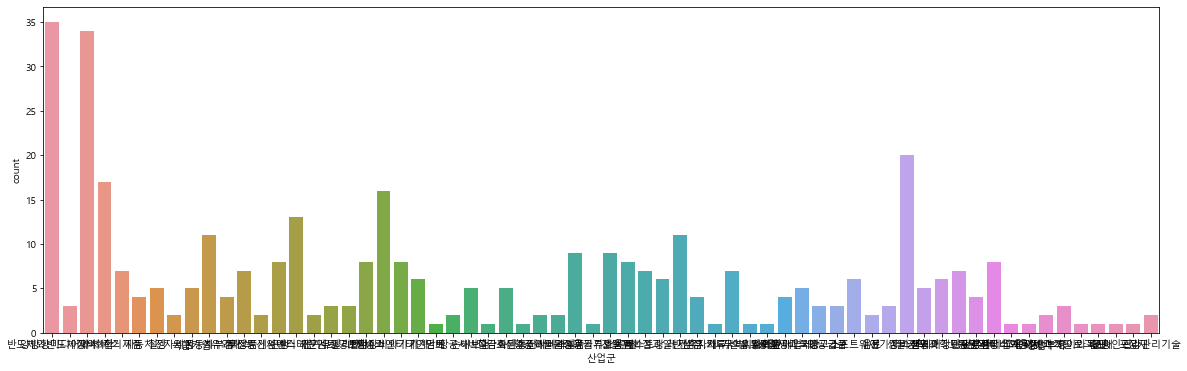

In [293]:
import seaborn as sns
plt.figure(figsize=(20,6))
sns.countplot(stock_list.산업군)

In [297]:
def draw_plot(company_lst, start_date='20200101', end_date='20201231'):
    stock_lst = []
    for company in company_lst:
        sample_code = stock_list[stock_list.종목명 == company].종목코드.values[0]
        data = fdr.DataReader(sample_code, start = start_date, end = end_date).Close
        data = (data - data.mean()) / data.std()
        plt.plot(data, label = company)
        
    #plt.legend()
    plt.show()  

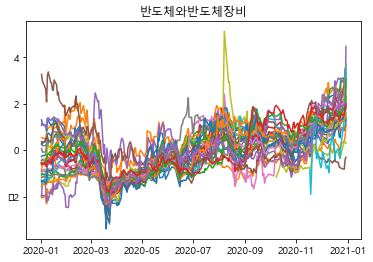

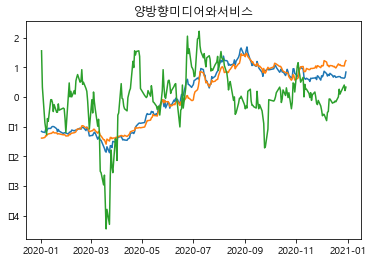

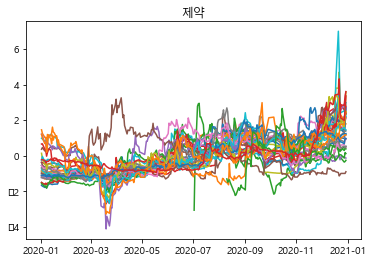

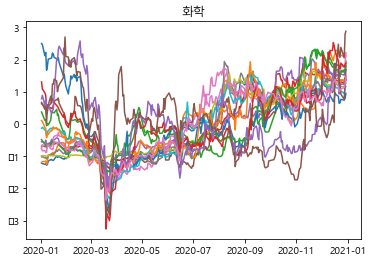

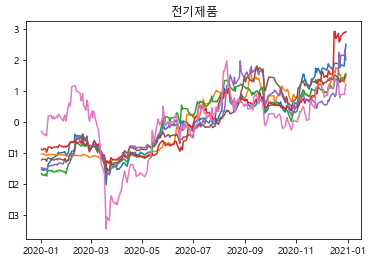

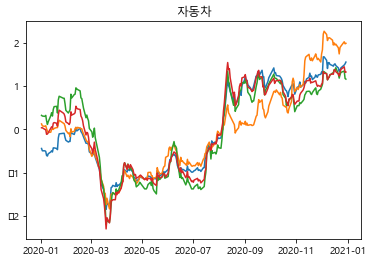

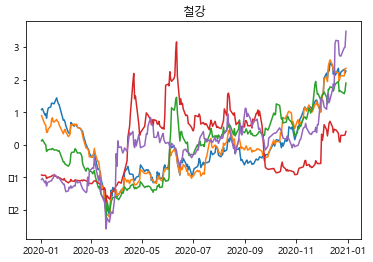

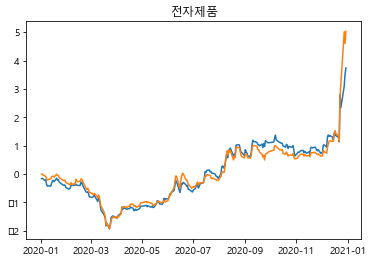

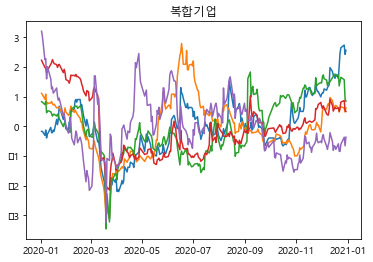

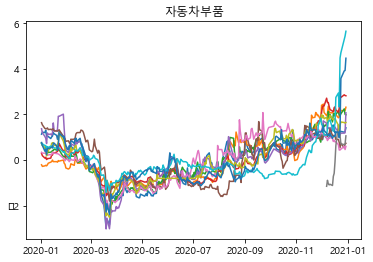

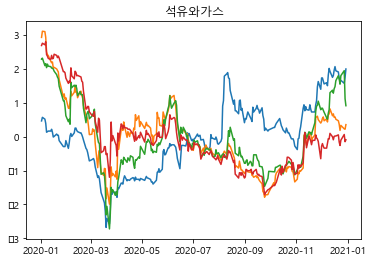

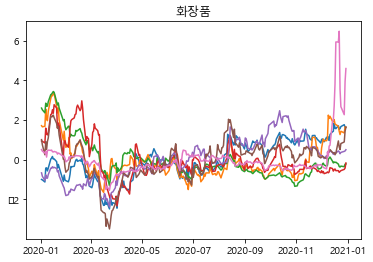

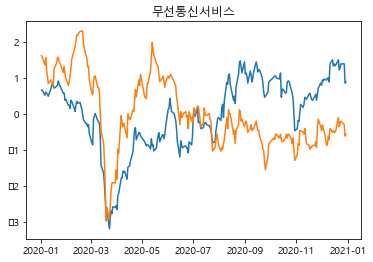

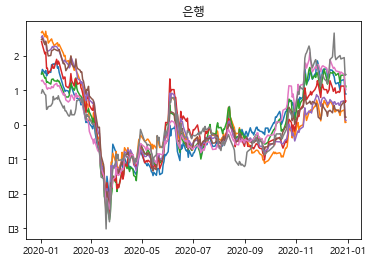

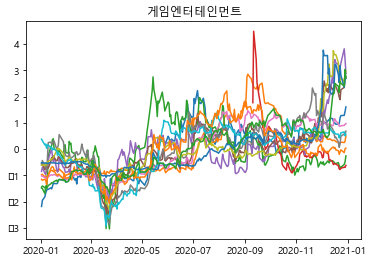

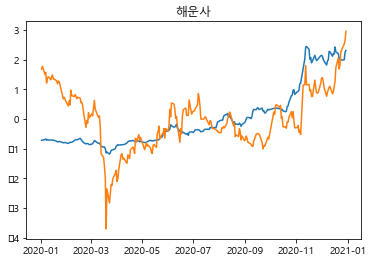

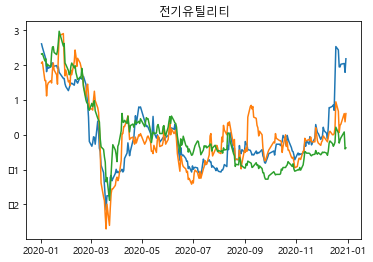

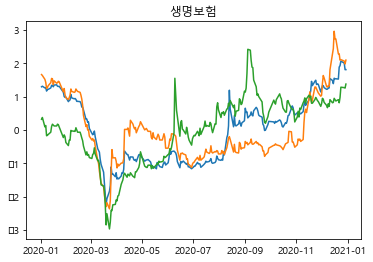

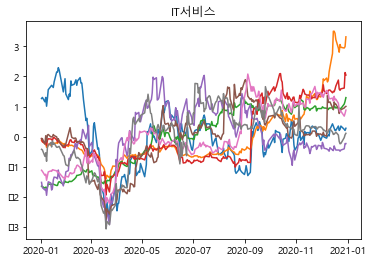

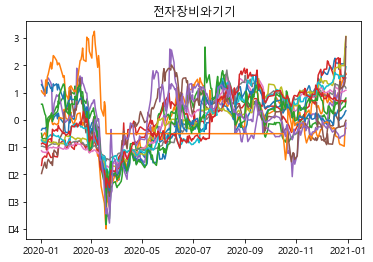

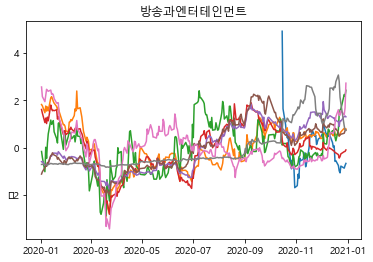

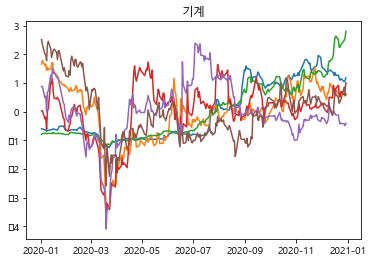

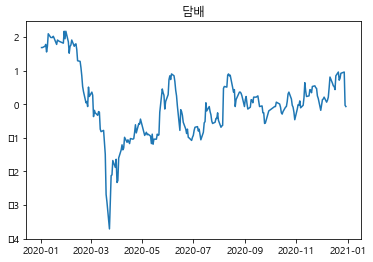

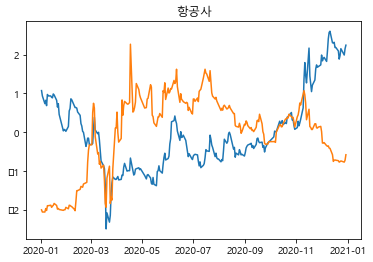

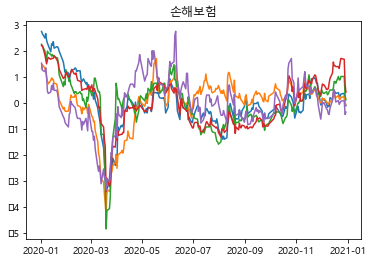

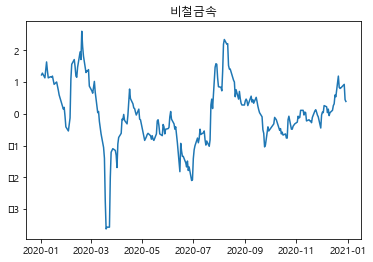

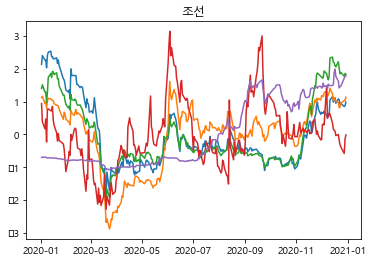

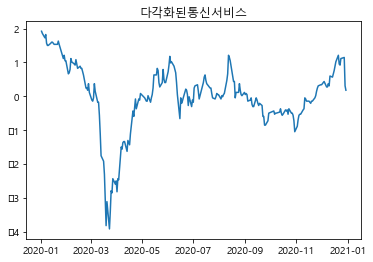

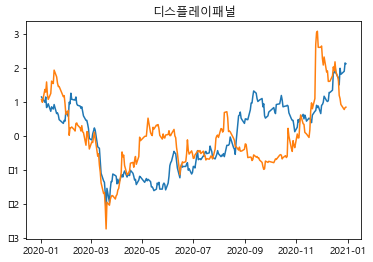

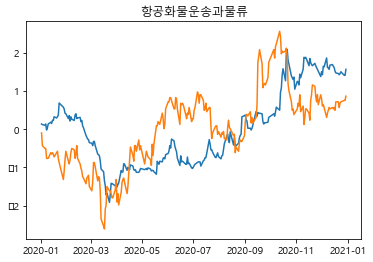

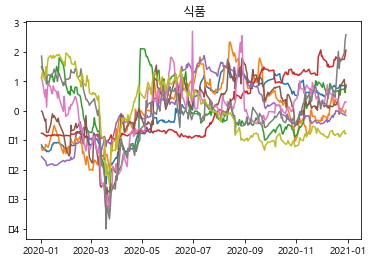

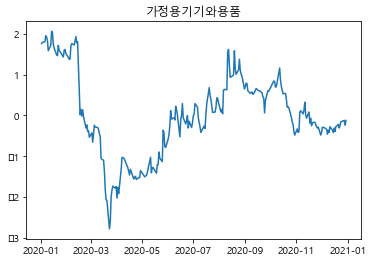

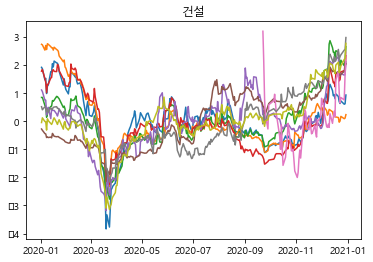

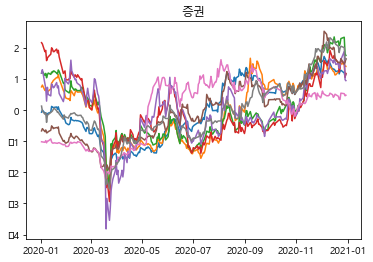

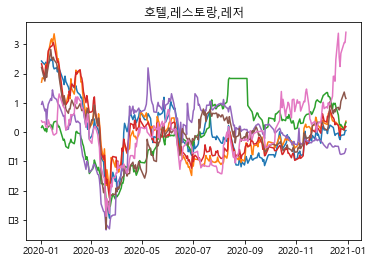

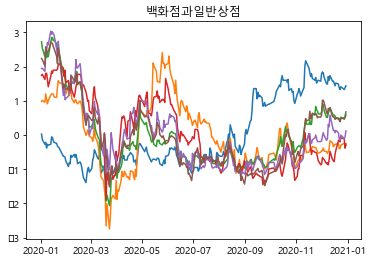

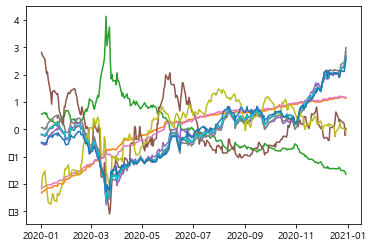

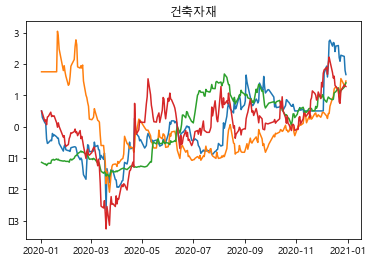

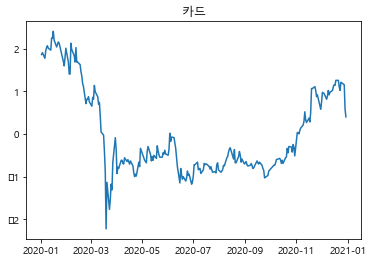

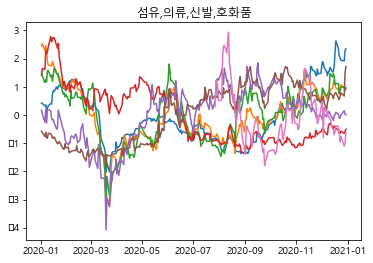

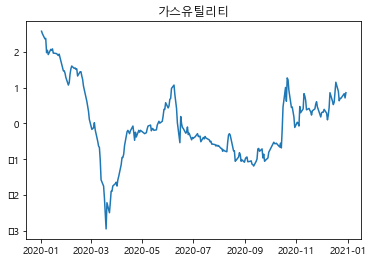

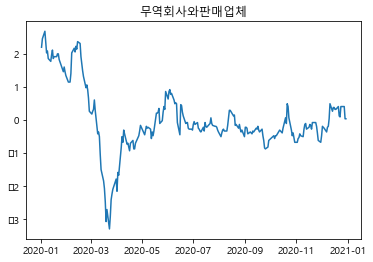

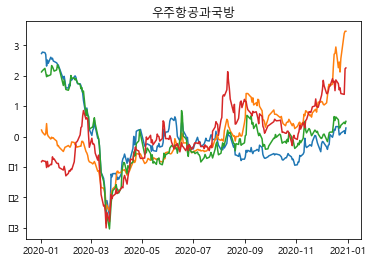

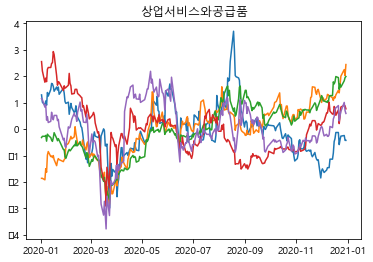

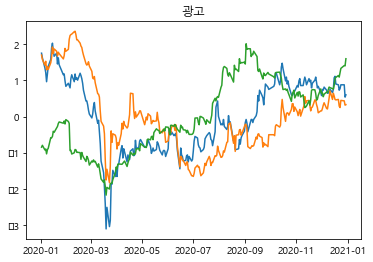

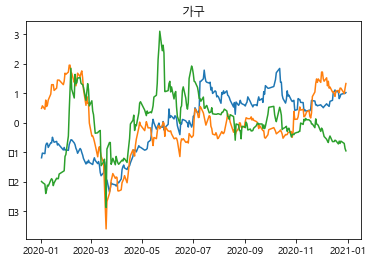

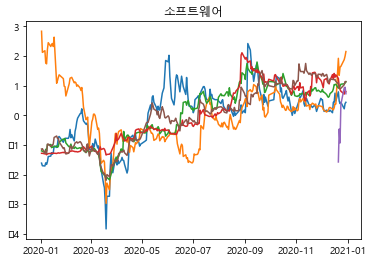

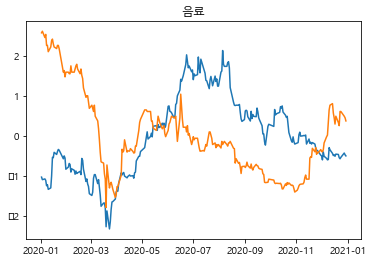

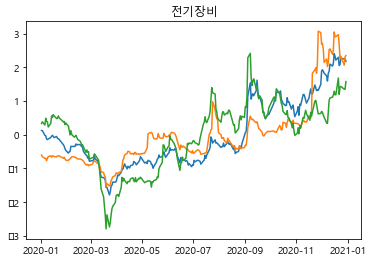

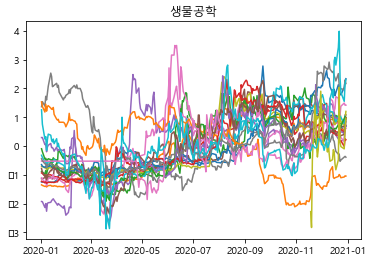

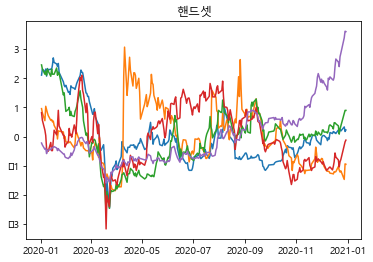

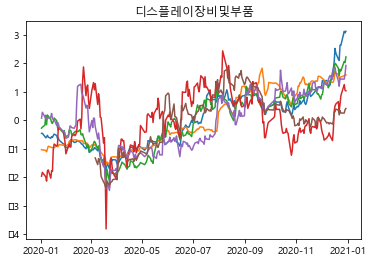

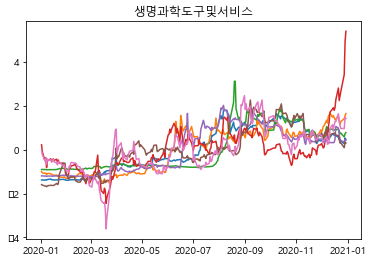

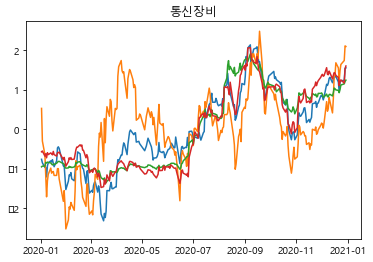

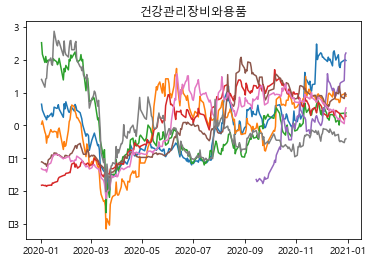

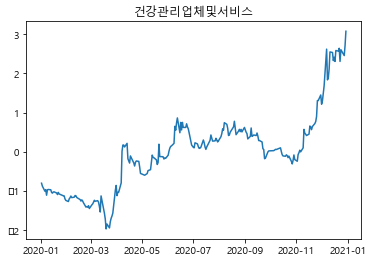

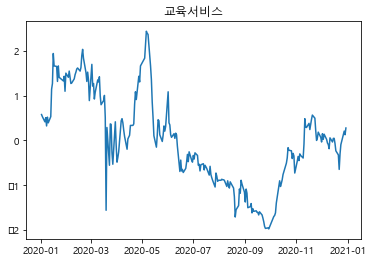

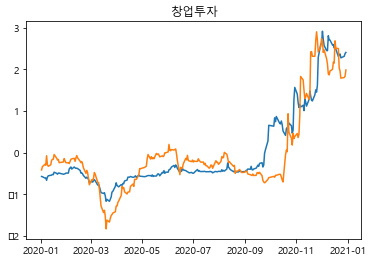

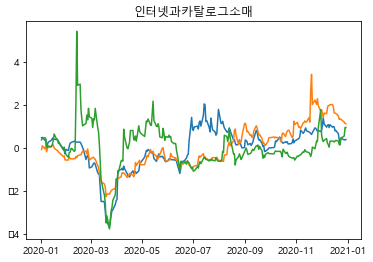

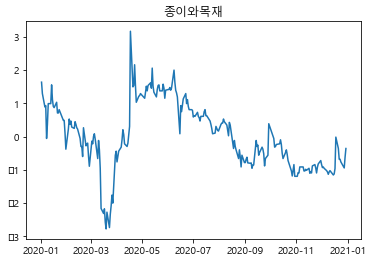

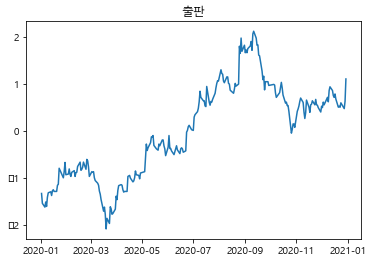

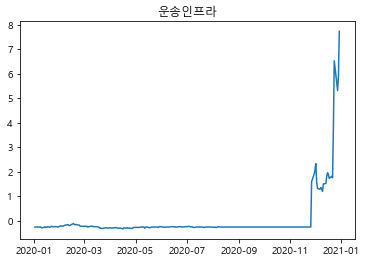

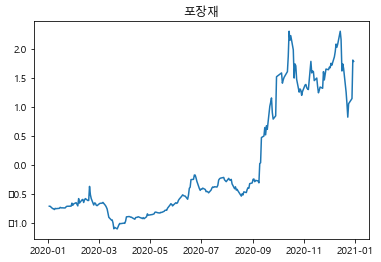

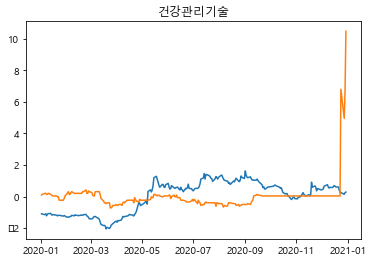

In [303]:
for sector in stock_list.산업군.unique():
    plt.title(sector)
    draw_plot(stock_list[stock_list.산업군==sector].종목명.tolist())

# parameter tuning

In [58]:
count_df = stock_list.groupby('산업군').count().sort_values(by='종목명', ascending=False)['종목명'].reset_index()
len(count_df[count_df.종목명 >= 10])

7

In [59]:
industry_lst = count_df[count_df.종목명 >= 10].산업군.tolist()
#industry_lst.remove('') # 미분류 산업군은 삭제

In [60]:
industry_lst

['반도체와반도체장비', '제약', '생물공학', '화학', '전자장비와기기', '게임엔터테인먼트', '자동차부품']

In [14]:
def NMAE(y_true, y_hat):
    #y_true, y_hat = y_true.values, y_hat.values
    return mean_absolute_error(y_true, y_hat) / np.mean(np.abs(y_true))

In [11]:
params_grid = {'changepoint_prior_scale':[0.1,0.05,0.03],
               'changepoint_range' : [0.4,0.6,0.8],
               'fourier_order' : [5,10],
               'period':[0.1,0.3,0.5]
               }
grid = ParameterGrid(params_grid)

In [429]:
model_parameters = pd.DataFrame(columns = ['code',
                                           'industry',
                                           'NMAE',
                                           'changepoint_prior_scale',
                                           'changepoint_range',
                                           'fourier_order',
                                           'period'
                                           ])

for industry in tqdm(industry_lst, position=2):
    code_list = stock_list[stock_list.산업군==industry].종목코드.tolist()
    
    random.seed(0)
    samples = random.sample(code_list, 5)
    
    for code in tqdm(samples, position=1):
        data_raw = fdr.DataReader(code, start = '20210101', end = '20210829').Close

        sc = StandardScaler()
        data_scaled = pd.DataFrame({'ds':data_raw.index,
                                    'y':sc.fit_transform(data_raw.values.reshape(-1,1)).flatten()})
        
        train = data_scaled[data_scaled.ds <= pd.to_datetime('2021-08-06')] 
        val = data_scaled[data_scaled.ds > pd.to_datetime('2021-08-06')] 
        
        for p in tqdm(grid, position=0):
            prophet = Prophet(seasonality_mode='multiplicative', 
                              yearly_seasonality=False,
                              weekly_seasonality=False,
                              daily_seasonality=False,
                              changepoint_prior_scale=p['changepoint_prior_scale'],
                              changepoint_range=p['changepoint_range'],
                              )
            prophet.add_seasonality(name='seasonality_1',period=p['period'],fourier_order=p['fourier_order'])
            prophet.fit(train)

            # 21일치를 예측합니다.
            future_data = prophet.make_future_dataframe(periods=21)
            forecast_data = prophet.predict(future_data)

            pred_y = forecast_data[forecast_data.ds.map(lambda x: x in val.ds.tolist())].yhat
            pred_y = sc.inverse_transform(pred_y.values.reshape(-1,1))
            
            y_true = sc.inverse_transform(val.y.values.reshape(-1,1))

            error =  NMAE(y_true, pred_y) * 100
            model_parameters = model_parameters.append({'code':code,
                                                        'industry':industry,
                                                        'NMAE':error,
                                                        'changepoint_prior_scale':p['changepoint_prior_scale'],
                                                        'changepoint_range':p['changepoint_range'],
                                                        'fourier_order':p['fourier_order'],
                                                        'period':p['period'],
                                                        },ignore_index=True)



100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:05<00:00,  1.21s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:09<00:00,  1.29s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:04<00:00,  1.20s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:03<00:00,  1.17s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:17<00:00,  1.44s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:40<00:00, 68.15s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:08<00:00,  1.27s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:06<00:00,  1.24s/it]

100%|████████████████████████

In [61]:
other_lst = list(set(stock_list.산업군)-set(industry_lst))
code_list = stock_list[stock_list.산업군.map(lambda x: x not in industry_lst)].종목코드.tolist()

In [64]:
code_list[:5]

['035420', '035720', '006400', '005380', '000270']

In [65]:
random.seed(0)
samples = random.sample(code_list, 10)

for code in tqdm(samples, position=1):
    data_raw = fdr.DataReader(code, start = '20210101', end = '20210829').Close

    sc = StandardScaler()
    data_scaled = pd.DataFrame({'ds':data_raw.index,
                                'y':sc.fit_transform(data_raw.values.reshape(-1,1)).flatten()})

    train = data_scaled[data_scaled.ds <= pd.to_datetime('2021-08-06')] 
    val = data_scaled[data_scaled.ds > pd.to_datetime('2021-08-06')] 

    for p in tqdm(grid, position=0):
        prophet = Prophet(seasonality_mode='multiplicative', 
                          yearly_seasonality=False,
                          weekly_seasonality=False,
                          daily_seasonality=False,
                          changepoint_prior_scale=p['changepoint_prior_scale'],
                          changepoint_range=p['changepoint_range'],
                          )
        prophet.add_seasonality(name='seasonality_1',period=p['period'],fourier_order=p['fourier_order'])
        prophet.fit(train)

        # 21일치를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=21)
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data[forecast_data.ds.map(lambda x: x in val.ds.tolist())].yhat
        pred_y = sc.inverse_transform(pred_y.values.reshape(-1,1))

        y_true = sc.inverse_transform(val.y.values.reshape(-1,1))

        error =  NMAE(y_true, pred_y) * 100
        model_parameters = model_parameters.append({'code':code,
                                                    'industry':'기타',
                                                    'NMAE':error,
                                                    'changepoint_prior_scale':p['changepoint_prior_scale'],
                                                    'changepoint_range':p['changepoint_range'],
                                                    'fourier_order':p['fourier_order'],
                                                    'period':p['period'],
                                                    },ignore_index=True)


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:48<00:00,  2.01s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:27<00:00,  1.62s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:09<00:00,  1.29s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:22<00:00,  1.53s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:19<00:00,  1.47s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:12<00:00,  1.34s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:19<00:00,  1.47s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:25<00:00,  1.58s/it]

100%|██████████████████████████

In [76]:
model_parameters.sort_values(by=['industry','code','NMAE'], inplace=True)

In [77]:
model_parameters.to_csv('model_parameters.csv', index=False, encoding='CP949')

In [78]:
param_pivot= pd.pivot_table(data=model_parameters,
                   values='NMAE', 
                   index=['industry','changepoint_prior_scale','changepoint_range',
                         'fourier_order','period'],
                   columns=['code']).reset_index()

In [82]:
param_pivot.head(2)

code,industry,changepoint_prior_scale,changepoint_range,fourier_order,period,240,5935,6650,9150,9900,...,001440,008560,017670,029960,031430,033310,051600,267980,294870,mean
0,게임엔터테인먼트,0.03,0.4,5,0.1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.289673
1,게임엔터테인먼트,0.03,0.4,5,0.3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.852255


In [80]:
param_pivot['mean'] = np.nanmean(param_pivot.iloc[:,5:].values, axis=1)

In [84]:
param_pivot = param_pivot.drop(param_pivot.columns[5:-1], axis=1).sort_values(by=['industry','mean'])

In [98]:
param_pivot.index = range(len(param_pivot))
param_pivot.columns.name = ''

In [114]:
param_pivot['best']=0

for i in param_pivot.industry.unique():
    min_index = param_pivot[param_pivot.industry==i].index.min()
    param_pivot.loc[min_index,'best']=1

In [119]:
param_pivot.to_csv('model_parameters_pivot.csv', encoding='CP949', index=False)

# test with tuning

In [20]:
def preprocess_for_merge(x):
    if x not in industry_lst:
        return '기타'
    else:
        return x

In [24]:
best_param = param_pivot[param_pivot.best == 1]

In [21]:
stock_list['industry']=stock_list.산업군
stock_list.industry = stock_list.industry.map(lambda x: preprocess_for_merge(x))

In [26]:
info_train = pd.merge(stock_list.drop(['산업군'], axis=1),
                best_param.drop(['mean','best'], axis=1),
                how='left',
                on='industry')

In [27]:
info_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376 entries, 0 to 375
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   종목명                      376 non-null    object 
 1   종목코드                     376 non-null    object 
 2   상장시장                     376 non-null    object 
 3   industry                 376 non-null    object 
 4   changepoint_prior_scale  376 non-null    float64
 5   changepoint_range        376 non-null    float64
 6   fourier_order            376 non-null    int64  
 7   period                   376 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 26.4+ KB


In [28]:
info_train.head()

,종목명,종목코드,상장시장,industry,changepoint_prior_scale,changepoint_range,fourier_order,period
0,삼성전자,005930,KOSPI,반도체와반도체장비,0.1,0.6,5,0.3
1,SK하이닉스,000660,KOSPI,반도체와반도체장비,0.1,0.6,5,0.3
2,NAVER,035420,KOSPI,기타,0.1,0.8,10,0.1
3,카카오,035720,KOSPI,기타,0.1,0.8,10,0.1
4,삼성바이오로직스,207940,KOSPI,제약,0.1,0.8,5,0.3


In [33]:
submission = pd.read_csv('./open_week3/sample_submission_week3.csv')
target_day = pd.to_datetime(submission.Day).tolist()

for _, row in tqdm(info_train.iterrows()):
    code= row['종목코드']
    data_raw = fdr.DataReader(code, start = '20210101', end = '20210829').Close

    sc = StandardScaler()
    data_scaled = pd.DataFrame({'ds':data_raw.index,
                                'y':sc.fit_transform(data_raw.values.reshape(-1,1)).flatten()})

    m = Prophet(seasonality_mode='multiplicative', 
                yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                changepoint_prior_scale=row['changepoint_prior_scale'],
                changepoint_range=row['changepoint_range']
               )
    m.add_seasonality(name='seasonality_1',
                      period=row['period'],
                      fourier_order=row['fourier_order'])

    m.fit(data_scaled)
    future = m.make_future_dataframe(periods=7)
    forecast = m.predict(future)

    result = forecast[['ds','yhat']]
    result.yhat = sc.inverse_transform(result.yhat.values.reshape(-1,1))

    result_1 = result[result.ds.map(lambda x:x in target_day[:5])].yhat.values
    
    data_raw = fdr.DataReader(code, start = '20210101', end = '20210912').Close

    sc = StandardScaler()
    data_scaled = pd.DataFrame({'ds':data_raw.index,
                                'y':sc.fit_transform(data_raw.values.reshape(-1,1)).flatten()})

    m = Prophet(seasonality_mode='multiplicative', 
                yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                changepoint_prior_scale=row['changepoint_prior_scale'],
                changepoint_range=row['changepoint_range']
               )
    m.add_seasonality(name='seasonality_1',
                      period=row['period'],
                      fourier_order=row['fourier_order'])

    m.fit(data_scaled)
    future = m.make_future_dataframe(periods=7)
    forecast = m.predict(future)

    result = forecast[['ds','yhat']]
    result.yhat = sc.inverse_transform(result.yhat.values.reshape(-1,1))
    
    result_2 = result[result.ds.map(lambda x:x in target_day[5:])].yhat.values
    
    submission[code]=np.vstack([result_1.reshape(-1,1),result_2.reshape(-1,1)]).flatten()

376it [19:55,  3.18s/it]


In [35]:
submission.to_csv('./submit/submission_{}.csv'.format(dt.now().strftime('%m%d_%H%M')), index=False)

# parameter tuning_more cluster
- 성능: 6.4

In [12]:
params_grid = {'changepoint_prior_scale':[0.1,0.05,0.03],
               'changepoint_range' : [0.4,0.6,0.8],
               'fourier_order' : [5,10],
               'period':[0.1,0.3,0.5]
               }
grid = ParameterGrid(params_grid)

In [4]:
count_df = stock_list.groupby('산업군').count().sort_values(by='종목명', ascending=False)['종목명'].reset_index()
industry_lst = count_df[count_df.종목명 >= 5].산업군.tolist()

In [5]:
len(industry_lst)

29

In [9]:
model_parameters = pd.DataFrame(columns = ['code',
                                           'industry',
                                           'NMAE',
                                           'changepoint_prior_scale',
                                           'changepoint_range',
                                           'fourier_order',
                                           'period'
                                           ])

for industry in tqdm(industry_lst, position=2):
    code_list = stock_list[stock_list.산업군==industry].종목코드.tolist()
    
    random.seed(0)
    samples = random.sample(code_list, 5)
    
    for code in tqdm(samples, position=1):
        data_raw = fdr.DataReader(code, start = '20210101', end = '20210829').Close

        sc = StandardScaler()
        data_scaled = pd.DataFrame({'ds':data_raw.index,
                                    'y':sc.fit_transform(data_raw.values.reshape(-1,1)).flatten()})
        
        train = data_scaled[data_scaled.ds <= pd.to_datetime('2021-08-06')] 
        val = data_scaled[data_scaled.ds > pd.to_datetime('2021-08-06')] 
        
        for p in tqdm(grid, position=0):
            prophet = Prophet(seasonality_mode='multiplicative', 
                              yearly_seasonality=False,
                              weekly_seasonality=False,
                              daily_seasonality=False,
                              changepoint_prior_scale=p['changepoint_prior_scale'],
                              changepoint_range=p['changepoint_range'],
                              )
            prophet.add_seasonality(name='seasonality_1',period=p['period'],fourier_order=p['fourier_order'])
            prophet.fit(train)

            # 21일치를 예측합니다.
            future_data = prophet.make_future_dataframe(periods=21)
            forecast_data = prophet.predict(future_data)

            pred_y = forecast_data[forecast_data.ds.map(lambda x: x in val.ds.tolist())].yhat
            pred_y = sc.inverse_transform(pred_y.values.reshape(-1,1))
            
            y_true = sc.inverse_transform(val.y.values.reshape(-1,1))

            error =  NMAE(y_true, pred_y) * 100
            model_parameters = model_parameters.append({'code':code,
                                                        'industry':industry,
                                                        'NMAE':error,
                                                        'changepoint_prior_scale':p['changepoint_prior_scale'],
                                                        'changepoint_range':p['changepoint_range'],
                                                        'fourier_order':p['fourier_order'],
                                                        'period':p['period'],
                                                        },ignore_index=True)



100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:07<00:00,  1.25s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:24<00:00,  1.56s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:20<00:00,  1.50s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:14<00:00,  1.39s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:25<00:00,  1.59s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:34<00:00, 78.83s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:17<00:00,  1.44s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:14<00:00,  1.37s/it]

100%|████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:57<00:00,  1.06s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:07<00:00,  1.24s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:22<00:00, 64.41s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:06<00:00,  1.23s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:10<00:00,  1.30s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:03<00:00,  1.18s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:04<00:00,  1.20s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:04<00:00,  1.20s/it]

100%|██████████████████████████

In [6]:
other_lst = list(set(stock_list.산업군)-set(industry_lst))
code_list = stock_list[stock_list.산업군.map(lambda x: x not in industry_lst)].종목코드.tolist()

In [8]:
code_list[:5], len(code_list)

(['035420', '035720', '005380', '000270', '066570'], 83)

In [9]:
model_parameters

,code,industry,NMAE,changepoint_prior_scale,changepoint_range,fourier_order,period
0,61970,반도체와반도체장비,5.158235,0.10,0.4,5,0.1
1,61970,반도체와반도체장비,5.078319,0.10,0.4,5,0.3
2,61970,반도체와반도체장비,5.158235,0.10,0.4,5,0.5
3,61970,반도체와반도체장비,5.108822,0.10,0.4,10,0.1
4,61970,반도체와반도체장비,5.117974,0.10,0.4,10,0.3
...,...,...,...,...,...,...,...
7825,91700,핸드셋,2.695266,0.03,0.8,5,0.3
7826,91700,핸드셋,2.585315,0.03,0.8,5,0.5
7827,91700,핸드셋,2.582801,0.03,0.8,10,0.1
7828,91700,핸드셋,2.670692,0.03,0.8,10,0.3


In [15]:
random.seed(0)
samples = random.sample(code_list, 10)

for code in tqdm(samples, position=1):
    data_raw = fdr.DataReader(code, start = '20210101', end = '20210829').Close

    sc = StandardScaler()
    data_scaled = pd.DataFrame({'ds':data_raw.index,
                                'y':sc.fit_transform(data_raw.values.reshape(-1,1)).flatten()})

    train = data_scaled[data_scaled.ds <= pd.to_datetime('2021-08-06')] 
    val = data_scaled[data_scaled.ds > pd.to_datetime('2021-08-06')] 

    for p in tqdm(grid, position=0):
        prophet = Prophet(seasonality_mode='multiplicative', 
                          yearly_seasonality=False,
                          weekly_seasonality=False,
                          daily_seasonality=False,
                          changepoint_prior_scale=p['changepoint_prior_scale'],
                          changepoint_range=p['changepoint_range'],
                          )
        prophet.add_seasonality(name='seasonality_1',period=p['period'],fourier_order=p['fourier_order'])
        prophet.fit(train)

        # 21일치를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=21)
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data[forecast_data.ds.map(lambda x: x in val.ds.tolist())].yhat
        pred_y = sc.inverse_transform(pred_y.values.reshape(-1,1))

        y_true = sc.inverse_transform(val.y.values.reshape(-1,1))

        error =  NMAE(y_true, pred_y) * 100
        model_parameters = model_parameters.append({'code':code,
                                                    'industry':'기타',
                                                    'NMAE':error,
                                                    'changepoint_prior_scale':p['changepoint_prior_scale'],
                                                    'changepoint_range':p['changepoint_range'],
                                                    'fourier_order':p['fourier_order'],
                                                    'period':p['period'],
                                                    },ignore_index=True)


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:09<00:00,  1.29s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:58<00:00,  1.09s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:57<00:00,  1.07s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:10<00:00,  1.31s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:03<00:00,  1.17s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:03<00:00,  1.17s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:13<00:00,  1.36s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [01:05<00:00,  1.20s/it]

100%|██████████████████████████

In [16]:
model_parameters.sort_values(by=['industry','code','NMAE'], inplace=True)

In [17]:
model_parameters.to_csv('model_parameters_update.csv', index=False, encoding='CP949')

In [18]:
param_pivot= pd.pivot_table(data=model_parameters,
                   values='NMAE', 
                   index=['industry','changepoint_prior_scale','changepoint_range',
                         'fourier_order','period'],
                   columns=['code']).reset_index()
param_pivot['mean'] = np.nanmean(param_pivot.iloc[:,5:].values, axis=1)
param_pivot = param_pivot.drop(param_pivot.columns[5:-1], axis=1).sort_values(by=['industry','mean'])

param_pivot.index = range(len(param_pivot))
param_pivot.columns.name = ''

param_pivot['best']=0

for i in param_pivot.industry.unique():
    min_index = param_pivot[param_pivot.industry==i].index.min()
    param_pivot.loc[min_index,'best']=1

In [19]:
param_pivot.to_csv('model_parameters_pivot_update.csv', encoding='CP949', index=False)